## ClearMap cell detection Analysis Tutorial, Part 1.

### This is a brief tutorial designed to analyze detected c-Fos+ cells among behavioral groups. 
It outlines the basic statistics you may want to run for an experiment in which you have collected and cleared brains after a behavior and stained for c-Fos. 
#### Note: It assumes you have processed and done quality control on brain volumes processed through T.Pisano/Z.Dhanerawala's package, ClearMapCluster. 
Before beginning the tutorial, check that each brain in your processed directory has a csv file named `"Annotated_counts_[..]"`. 

In [2]:
#import relevant modules

import os, numpy as np, pandas as pd, scipy, itertools, sys, json, seaborn as sns
import matplotlib.pyplot as plt, matplotlib as mpl

#these are formatting settings useful for importing the exported plots into image editing software later (Illustrator)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["xtick.major.size"] = 6
mpl.rcParams["ytick.major.size"] = 6

### Defining functions

Below we are going to define 2 key functions used to do analysis: one, to traverse through the Allen ontology and find parent and child structures for each brain region, and another to compile the composite dataframe using the individual dataframes generated per brain. 

#### Note: You will generally not have to modify these functions unless you are trying to troubleshoot an error.

In [3]:
def get_progeny(dic,parent_structure,progeny_list):
    """ 
    ---PURPOSE---
    Get a list of all progeny of a structure name.
    This is a recursive function which is why progeny_list is an
    argument and is not returned.
    ---INPUT---
    dic                  A dictionary representing the JSON file 
                         which contains the ontology of interest
    parent_structure     The structure
    progeny_list         The list to which this function will 
                         append the progeny structures. 
    """
    if 'msg' in list(dic.keys()): dic = dic['msg'][0]
    
    name = dic.get("name")
    children = dic.get("children")
    if name == parent_structure:
        for child in children: # child is a dict
            child_name = child.get("name")
            progeny_list.append(child_name)
            get_progeny(child,parent_structure=child_name,progeny_list=progeny_list)
        return
    
    for child in children:
        child_name = child.get("name")
        get_progeny(child,parent_structure=parent_structure,progeny_list=progeny_list)
    return 

def generate_data_frame(conditions, lst, pth, flnm, 
                        exclude, ontology_file, scale = 0.025):
    """ 
    used to make a pooled csv file of all cell counts in an experiment
    inputs:
        conditions: zip of file names + condition
        lst: list of file names run through analysis
        pth: path to save csv output
        scale: atlas scale, default 25 um/voxel (0.025 mm/voxel); change if using a different atlas resolution
    """
    #open ontology file
    with open(ontology_file) as json_file:
        ontology_dict = json.load(json_file)

    #generate data frame
    bglst=[]
    for fl in lst:
        #extract out info
        nm = os.path.basename(fl)
        #make dataframe
        df = pd.read_csv(fl+"/%s.csv" % flnm)[1:] #remove previous headers
        print(nm, df.shape)
        df = df.replace(np.nan, "", regex=True)
        df["Brain"] = nm
        df["Condition"] = conditions[nm]
        
        #sum up ontology for each structure
        for struct in df.name.values:
            progeny = []; counts = []
            get_progeny(ontology_dict, struct, progeny)
            #add structure counts to itself
            counts.append(df[df.name == struct]["counts"].values[0])
            for progen in progeny:
                try:
                    counts.append(df[df.name == progen]["counts"].values[0])
                except:
                    counts.append(0)
            df.loc[df.name == struct, "counts"] = np.sum(np.array(counts))
        
        #remove structures you don't want to analyze
        for soi in exclude:
            df = df[df.name != soi]
            progeny = []; get_progeny(ontology_dict, soi, progeny)
            for progen in progeny:
                df = df[df.name != progen]
        
        #append to composite dataframe
        bglst.append(df)

    df = pd.concat(bglst)
    df["counts"] = df["counts"].apply(int)

    df = df.drop(columns = ["Unnamed: 0"])
    #get all brain names
    brains = np.unique(df.Brain.values)
    
    #save total counts in dict
    total_counts = {}
    percents = {}
    #for each brain, get total counts
    for brain in brains:
        total_counts[brain] = df[df.Brain == brain].counts.sum(0)               
    percents = [df[df.Brain == brain].counts.apply(lambda x: (x/total_counts[brain])*100).astype("float64") for brain in brains]
    #concantenate together
    df_percent = pd.concat(percents)
    df["percent"] = df_percent
    df["density"] = df[df.voxels_in_structure > 0].apply(lambda x:x.counts/(float(x.voxels_in_structure*(scale**3))), 1)
    
    df.to_csv(pth, index = None)
    
    return pth

### Setting paths

Below we are going to define variables and paths needed to import and export our analysis dataframe. Generally these will be system dependent, and experiment dependent, so make sure you modify these accordingly.

#### Note: For Windows OS, the path string will look different. Make sure you check and set the paths according to what makes sense for your OS.
E.g. In Windows, if you have mounted a file server under disk name "H:", your path to the `LightSheetData` fileshare should look something like this:
`df_pth = r"H:\falkner-mouse\allen_atlas\allen_id_table_w_voxel_counts.xlsx"`.

The "r" in front of the path is required for Windows string formats.

In [4]:
#set appropriate paths
df_pth = "/jukebox/LightSheetData/falkner-mouse/allen_atlas/allen_id_table_w_voxel_counts.xlsx"
ann_pth = "/jukebox/LightSheetData/falkner-mouse/allen_atlas/annotation_2017_25um_sagittal_forDVscans.nrrd"
atl_pth = "/jukebox/LightSheetData/falkner-mouse/allen_atlas/average_template_25_sagittal_forDVscans.tif"
ontology_file = "/jukebox/LightSheetData/falkner-mouse/allen_atlas/allen.json"
src = "/jukebox/LightSheetData/falkner-mouse/scooter/clearmap_processed"
dst = "/jukebox/LightSheetData/falkner-mouse/scooter/pooled_analysis" #where all output will be saved

if not os.path.exists(dst): os.mkdir(dst)
pth = os.path.join(dst, "cell_counts.csv") #destination to save out composite dataframe

#get files that have annotated counts per brain
lst = [os.path.join(src, fld) for fld in os.listdir(src) 
       if os.path.exists(os.path.join(os.path.join(src, fld), 
                                                     "Annotated_counts.csv"))]; lst.sort()

You will need to define animal names and condition variables based on your experimental paradigm. Typically you would have all your processed brains organized in one directory, and each brain name would correspond to a behavioral condition:
E.g. `mfnp3` was part of the `male-female` behavior group. 

Using this info, you can define the animals and corresponding behavioral conditions they belong to in the 2 lists below. This will be useful in making the composite dataframe and running statistical tests later.

In [ ]:
#conditions based on experiment - SET AND DOUBLE CHECK THESE MANUALLY
nms = ["mfnp3", "fmnp4", "mfnp2", "mmnp4", "mmnp6", 
       "mmnp5", "fmnp6", "fmnp5"]
#above animal name position should correspond to condition
cond = ["male-female", "female-male", "male-female", "male-male", "male-male",
        "male-male", "female-male", "female-male"]
conditions = {n:c for n,c in zip(nms, cond)}

To find brain regions that have elevated c-Fos+ cells, you will be comparing across the whole brain. Optionally, you can chose to name regions defined in the [Allen ontology](http://atlas.brain-map.org/atlas?atlas=2&plate=100883867) that you would like to exclude from these comparisons. Here we exclude ventricles and white matter tracts as these do not have neurons in the mouse brain.

In [ ]:
#name structures you want to exclude from analysis
exclude = ["ventricular systems", "fiber tracts", "grooves"]

### Make composite dataframe

Now we can run the function to make the composite dataframe:

In [5]:
csv_pth = generate_data_frame(conditions, lst, pth, "Annotated_counts", exclude, ontology_file)

fmnp4 (582, 8)
fmnp5 (583, 8)
fmnp6 (583, 8)
mfnp2 (586, 8)
mfnp3 (587, 8)
mmnp4 (578, 8)
mmnp5 (569, 8)
mmnp6 (585, 8)


You can print out a portion of the generated dataframe to see what it looks like, or inspect it in Excel.

In [6]:
df = pd.read_csv(csv_pth)
df.head(n = 10)

,id,counts,name,acronym,parent_name,parent_acronym,voxels_in_structure,Brain,Condition,percent,density
0,2.0,44,"Primary somatosensory area, mouth, layer 6b",SSp-m6b,"Primary somatosensory area, mouth",SSp-m,7339.0,fmnp4,female-male,0.007437,383.703502
1,7.0,615,Principal sensory nucleus of the trigeminal,PSV,"Pons, sensory related",P-sen,70327.0,fmnp4,female-male,0.103943,559.671250
2,9.0,137,"Primary somatosensory area, trunk, layer 6a",SSp-tr6a,"Primary somatosensory area, trunk",SSp-tr,14877.0,fmnp4,female-male,0.023155,589.366136
3,10.0,1074,"Superior colliculus, motor related, intermedia...",SCig,"Superior colliculus, motor related",SCm,130357.0,fmnp4,female-male,0.181520,527.290441
4,12.0,70,Interfascicular nucleus raphe,IF,Midbrain raphe nuclei,RAmb,5559.0,fmnp4,female-male,0.011831,805.900342
5,15.0,257,Parataenial nucleus,PT,Midline group of the dorsal thalamus,MTN,14706.0,fmnp4,female-male,0.043436,1118.455052
6,17.0,1047,"Superior colliculus, motor related, intermedia...",SCiw,"Superior colliculus, motor related",SCm,133937.0,fmnp4,female-male,0.176957,500.294915
7,19.0,70,Induseum griseum,IG,Hippocampal region,HIP,7958.0,fmnp4,female-male,0.011831,562.955516
8,20.0,140,"Entorhinal area, lateral part, layer 2",ENTl2,"Entorhinal area, lateral part",ENTl,102602.0,fmnp4,female-male,0.023662,87.327732
9,23.0,231,Anterior amygdalar area,AAA,Striatum-like amygdalar nuclei,sAMY,31652.0,fmnp4,female-male,0.039042,467.079489


### Statistics

Then, we can run basic, group-wise statistics on the behavioral conditions in this experiment using the `condition` list defined earlier. We can start with a one-way ANOVA with a correction for multiple comparisons (Tukey HSD)

You can define the p-value cutoff you want to use:

In [7]:
cutoff = 0.05

And set the measure you want to use for your statistics (cell density, cell count, normalized cell count, etc.)

In [8]:
#measure to use for tests
measure = "density" #you can change this to count, or percent later 

Then run the statistics for each structure:

In [9]:
#import modules for one way anova
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison

#read csv generated above
df = pd.read_csv(csv_pth, index_col = None)

#formatting to include structure name and parent name
df_anova = pd.DataFrame()
df_anova["name"] = df.name.unique()
df_anova["parent_name"] = [df.loc[df.name == nm, "parent_name"].values[0]
                           for nm in df_anova["name"]]
df_anova["tukeyhsd"] = np.ones(len(df_anova))*np.nan

for nm in np.unique(df.name.values): #to run on each structure
    f, pval = f_oneway(df[(df.name == nm) & (df.Condition == "male-male")][measure].values, 
                 df[(df.name == nm) & (df.Condition == "female-male")][measure].values,
                 df[(df.name == nm) & (df.Condition == "male-female")][measure].values)

    df_anova.loc[(df_anova["name"] == nm), "anova_f"] = f
    df_anova.loc[(df_anova["name"] == nm), "anova_pval"] = pval

    #doing post hoc on significant structures
    if pval < cutoff:
        mc = MultiComparison(df[df.name == nm][measure].values, df[df.name == nm ].Condition.values)
        result = mc.tukeyhsd(alpha=cutoff)

        df_anova.loc[(df_anova["name"] == nm), "tukeyhsd"] = np.min(result.pvalues)

df_anova.to_csv(os.path.join(dst, "one_way_anova_{}.csv".format(measure)))

/home/wanglab/anaconda3/envs/lightsheet/lib/python3.7/site-packages/scipy/stats/stats.py:3339: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)


Finally, you can use the results of the ANOVA to visualize the significant structures per group, using seaborn.

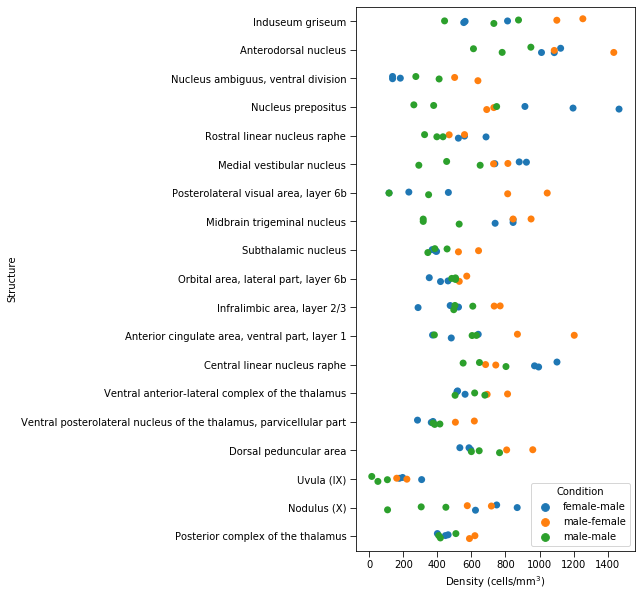

In [10]:
#find structures with multiple comparisons corrections    
sig_structs = df_anova[(df_anova.anova_pval < 0.05) & 
                        (df_anova.tukeyhsd < 0.05)].name.values
#plot the ones with lower density separately
sig_structures_ld = [xx for xx in sig_structs 
                     if df[df.name == xx][measure].mean() < 100]

df_nm = df[(df.name.isin(sig_structs)) & (~df.name.isin(sig_structures_ld))]
fig, ax = plt.subplots(figsize=(5,10))
sns.stripplot(y = "name", x = measure, hue = "Condition", data = df_nm,
            orient = "h", size=7)
#you can also choose to uncomment the lines below and make boxplots instead
# sns.boxplot(y = "name", x = "density", hue = "Condition", data = df_nm,
#             orient = "h", showfliers=False, showcaps=False, 
#         boxprops={'facecolor':'None'})
plt.xlabel("Density (cells/mm$^3$)")
plt.ylabel("Structure")
#save out
plt.savefig(os.path.join(dst, "boxplots_%s.pdf" % measure), dpi = 300, bbox_inches = "tight")

You can make a separate plot for structures with lower densities that are too small to visualize on the above X-axis.

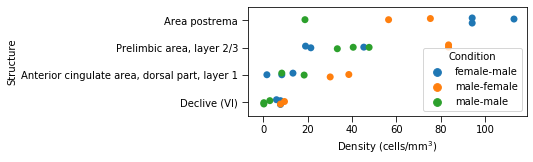

In [11]:
df_ld = df[df.name.isin(sig_structures_ld)]

fig, ax = plt.subplots(figsize=(5,2))
sns.stripplot(y = "name", x = measure, hue = "Condition", data = df_ld,
            orient = "h", size=7)

plt.xlabel("Density (cells/mm$^3$)")
plt.ylabel("Structure")
#save out
plt.savefig(os.path.join(dst, "boxplots_lower_%s.pdf") % measure, 
            dpi = 300, bbox_inches = "tight")

There are also many ways you can customize our plots for visualization, with color and labels. You can look up the parameters in seaborn and matplotlib in python for further info. 

E.g. You can change the color of your datapoints using `palette`, and adjust the size of your data points using `size`.

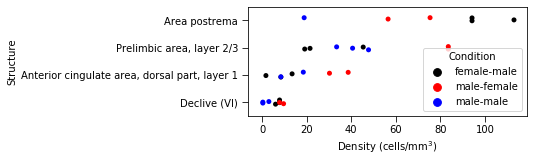

In [12]:
fig, ax = plt.subplots(figsize=(5,2))
sns.stripplot(y = "name", x = measure, hue = "Condition", data = df_ld,
            orient = "h", size=5, palette=["black", "red", "blue"])

plt.xlabel("Density (cells/mm$^3$)")
plt.ylabel("Structure")
plt.savefig(os.path.join(dst, "boxplots_lower_%s.pdf") % measure, 
            dpi = 300, bbox_inches = "tight")